In [1]:
import json
import ast
import matplotlib.pyplot as plt
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import sys, os
sys.path.append(os.path.abspath('..'))
from shared import generate



# *Indirect Speech Act Scenario*

### **Data Generation**

In [21]:
def generate_indirect_dialogue():
  return generate(model = 'gpt-4o',
        system = 'Generate dialogues as specified below.',
        query = '''Create 100 different and independent two-message dialogues. In each dialogue, Speaker 1 will first ask a question that is an indirect speech act. It should technically be answerable with a simple “Yes” or “No”, but must imply that the other person should provide more information. Language like “Have you thought about...”, “Is there...”, “Are there any...”, “Can you tell me...”, or “Do you know...” are good ways to phrase the question as a yes or no question. Never use “Do you think...”. Speaker 2 must misinterpret the question and respond with a "Yes." followed by a realistic phrase with no actual information, making its impact identical to a single-word "Yes". Speaker 2's response should mirror the action verb from Speaker 1's question. It should only be about the act of knowing, telling, or minding with no useful details about the topic itself. The answers should not be helpful in any way, not even slightly. The misinterpretation must be obvious from the dialogue itself. Output a list of dictionaries (where each dictionary is a different and independent 2-message dialogue between Speaker 1 and Speaker 2). Format your output exactly as follows: [{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."},{"Speaker 1": "Message by Speaker 1.", "Speaker 2":"Message by Speaker 2."}]
        

Do not generate Markdown or fenced code blocks. Here are some examples to guide you:

[    
  {
    "Speaker 1": "Are there any challenges you expect with the project?",
    "Speaker 2": "Yes, I foresee some challenges with it."
  },
  {
    "Speaker 1": "Can you tell me who is leading the next project?",
    "Speaker 2": "Yes, I can tell you who is leading it."
  },
  {
    "Speaker 1": "Do you know when the library is open today?",
    "Speaker 2": "Yes, I'm aware of the library hours."
  }
]

''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)

In [22]:
indirect_statements = []
while(len(indirect_statements) < 100):
    output = ast.literal_eval(generate_indirect_dialogue()['response'])
    indirect_statements = output + indirect_statements

indirect_statements = indirect_statements[0:100]


In [24]:
indirect_statements[0:2]


[{'Speaker 1': 'Do you know where the nearest coffee shop is?',
  'Speaker 2': 'Yes, I know where it is.'},
 {'Speaker 1': 'Is there any place we can park nearby?',
  'Speaker 2': 'Yes, there is a place to park.'}]

In [25]:
with open('../indirect_generated_data/indirect.json', 'w') as f:
    json.dump(indirect_statements, f, indent=2)


### **Identify and Explain Issue**


In [2]:
def identify_explain(dialogue):
  return generate(model = 'gpt-4o',
        system = 'Analyze the dialogue as specified below.',
        query = dialogue + '\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, your task is to evaluate which person, if any, needs to improve their communication. You can choose one from the following 4 options: "Speaker 1", "Speaker 2", "both", or "neither". Explain your decision. You must output a dictionary formatted exactly as follows with no extra tags or text: { "decision":"Speaker # or both or neither", "explanation":"A detailed explanation for your decision."}',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [3]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    
indirect_statements_generated[0:2]


[{'Speaker 1': 'Can you tell me when we need to arrive?',
  'Speaker 2': 'Yes, I can tell you.'},
 {'Speaker 1': 'Did you ask whether she’s coming for dinner?',
  'Speaker 2': 'Yes, I asked.'}]

In [4]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = identify_explain(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(8)))


In [5]:
with open('../indirect_analysis_data/identify_explain_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [6]:
with open('../indirect_analysis_data/identify_explain_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:2]


[{'decision': 'Speaker 2',
  'explanation': "Speaker 2's response, while affirming their ability to provide the information, does not actually answer the question asked by Speaker 1. Effective communication requires that the response should directly and clearly answer the question posed. In this case, Speaker 2 should have provided the specific information about when they need to arrive or at least indicated when they would provide that information if it was not immediately available."},
 {'decision': 'neither',
  'explanation': 'Both speaker 1 and speaker 2 communicated effectively. Speaker 1 asked a clear question regarding whether someone was asked about coming for dinner. Speaker 2 provided a clear and concise response confirming that the question was asked. There is no evidence of miscommunication or the need for improvement in this brief exchange.'}]

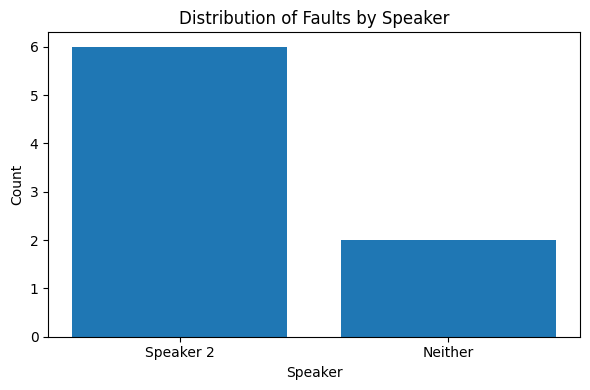

In [7]:
normalized_faults = []
for r in results_loaded:
    fault = r['decision'].strip().lower()
    if "1" in fault:
        normalized_faults.append("Speaker 1")
    elif "2" in fault:
        normalized_faults.append("Speaker 2")
    elif "both" in fault:
        normalized_faults.append("Both")
    else:
        normalized_faults.append("Neither")

# Count occurrences
fault_counts = Counter(normalized_faults)

# Plot
plt.figure(figsize=(6, 4))
plt.bar(fault_counts.keys(), fault_counts.values())
plt.title("Distribution of Faults by Speaker")
plt.xlabel("Speaker")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


### **Feedback on How Communication Can be Improved**

In [34]:
def provide_feedback(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nThe dialogue above contains an exchange between speaker 1 and speaker 2. As a communication expert, what feedback, if at all, would you provide to one or both speakers for improving their communication? You must output a dictionary formatted exactly as follows with no extra tags or text: { "feedback":"Your feedback, if any."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [35]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    
indirect_statements_generated[0:2]


[{'Speaker 1': 'Do you know where the nearest coffee shop is?',
  'Speaker 2': 'Yes, I know where it is.'},
 {'Speaker 1': 'Is there any place we can park nearby?',
  'Speaker 2': 'Yes, there is a place to park.'}]

In [36]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = provide_feedback(dialogue)['response']
    return ast.literal_eval(response)

with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [37]:
with open('../indirect_analysis_data/provide_feedback_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [38]:
with open('../indirect_analysis_data/provide_feedback_ctx_none.json') as f:
    results_loaded = json.load(f)

results_loaded[0:10]


[{'feedback': "Speaker 2 could improve communication by providing the actual location of the coffee shop instead of just confirming knowledge of its existence. For example, they could say, 'Yes, it's two blocks down on Main Street.'"},
 {'feedback': "The communication here is quite efficient and straightforward, accomplishing the goal in a clear and concise manner. However, Speaker 2 could provide more detailed information, such as the location or distance of the parking area, to further assist Speaker 1. For example, 'Yes, there's a parking lot about two blocks away.' This added detail would make the response more helpful."},
 {'feedback': 'Speaker 2 should provide the specific start time of the meeting to make the communication more effective.'},
 {'feedback': "The communication is clear but could be more informative. Speaker 2 should provide specific details about the updates instead of just confirming their existence. For example, 'Yes, there are updates. We have completed the init

### **Autistic vs Non-autistic Chances**


In [58]:
def autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [26]:
# def autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from an autistic person as opposed to an non-autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [59]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    


In [60]:
indirect_statements_generated[0:2]

[{'Speaker 1': 'Do you know where the nearest coffee shop is?',
  'Speaker 2': 'Yes, I know where it is.'},
 {'Speaker 1': 'Is there any place we can park nearby?',
  'Speaker 2': 'Yes, there is a place to park.'}]

In [61]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(response)
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [62]:
results[0:2]

[{'chance': 'high',
  'explanation': 'Autistic individuals are more likely to respond literally and directly to questions without providing additional context or details unless explicitly asked. The statement from Speaker 2 is direct and concise, fitting a communication style often observed in autistic individuals.'},
 {'chance': 'low',
  'explanation': 'The response from Speaker 2 is contextually appropriate and provides a direct answer to the question asked by Speaker 1. This level of social interaction and communication is typical of both autistic and non-autistic individuals. Therefore, there is no strong indication from this brief interaction to suggest the likelihood of Speaker 2 being autistic versus non-autistic is high.'}]

In [63]:
with open('../indirect_analysis_data/autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [64]:
def non_autistic_chances(dialogue):
  return generate(model = 'gpt-4o',
        system = '''Analyze the dialogue as specified below.''',
        query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" could be made by a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". Explain your answer. You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high", "explanation":"Explanation for your answer."}''',
        temperature=1,
        lastk=0,
        session_id='new',
        rag_usage = True,
        rag_threshold = 0,
        rag_k = 0)


In [34]:
# def non_autistic_chances(dialogue):
#   return generate(model = 'gpt-4o',
#         system = '''Analyze the dialogue as specified below.''',
#         query = dialogue + '''\n\nIn the dialogue above, what are the chances that the statement labeled "Speaker 2" is from a non-autistic person as opposed to an autistic person? Choose exactly one option: "Low", "Medium", or "High". You must output a dictionary formatted exactly as follows with no extra tags, fenced blocks or text: {"chance":"low, medium, or high"}''',
#         temperature=1,
#         lastk=0,
#         session_id='new',
#         rag_usage = True,
#         rag_threshold = 0,
#         rag_k = 0)


In [65]:
with open('../indirect_generated_data/indirect.json') as f:
    indirect_statements_generated = json.load(f)
    


In [66]:
indirect_statements_generated[0:2]

[{'Speaker 1': 'Do you know where the nearest coffee shop is?',
  'Speaker 2': 'Yes, I know where it is.'},
 {'Speaker 1': 'Is there any place we can park nearby?',
  'Speaker 2': 'Yes, there is a place to park.'}]

In [67]:
def process_dialogue(i):
    dialogue = '\n'.join([f"{speaker}: {statement}" for speaker, statement in indirect_statements_generated[i].items()])
    response = non_autistic_chances(dialogue)['response']
    try:
        return ast.literal_eval(response)
    except:
        print(response)
        print(i, "\n\n", dialogue, "\n\n")
        return ast.literal_eval("{'chance':'error', 'explanation':'error'}")
with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(process_dialogue, range(100)))


In [68]:
results[0:2]

[{'chance': 'medium',
  'explanation': "The statement made by Speaker 2 is factual and direct, which can be typical of both non-autistic and autistic communication styles. However, many non-autistic people might provide additional information or offer more context, such as giving directions immediately after acknowledging they know the location. Without further context, it's difficult to definitively determine the likelihood, hence 'medium' is the most suitable choice."},
 {'chance': 'high',
  'explanation': 'The response given by Speaker 2 is straightforward and directly answers the question posed by Speaker 1, which is typical of non-autistic communication. Non-autistic individuals often provide concise and relevant responses.'}]

In [69]:
with open('../indirect_analysis_data/non_autistic_chances_ctx_none.json', 'w') as f:
    json.dump(results, f, indent=2)


In [70]:
with open('../indirect_analysis_data/autistic_chances_ctx_none.json') as f:
    autistic_results_loaded = json.load(f)

autistic_results_loaded[0:2]


[{'chance': 'high',
  'explanation': 'Autistic individuals are more likely to respond literally and directly to questions without providing additional context or details unless explicitly asked. The statement from Speaker 2 is direct and concise, fitting a communication style often observed in autistic individuals.'},
 {'chance': 'low',
  'explanation': 'The response from Speaker 2 is contextually appropriate and provides a direct answer to the question asked by Speaker 1. This level of social interaction and communication is typical of both autistic and non-autistic individuals. Therefore, there is no strong indication from this brief interaction to suggest the likelihood of Speaker 2 being autistic versus non-autistic is high.'}]

In [71]:
with open('../indirect_analysis_data/non_autistic_chances_ctx_none.json') as f:
    non_autistic_results_loaded = json.load(f)

non_autistic_results_loaded[0:2]


[{'chance': 'medium',
  'explanation': "The statement made by Speaker 2 is factual and direct, which can be typical of both non-autistic and autistic communication styles. However, many non-autistic people might provide additional information or offer more context, such as giving directions immediately after acknowledging they know the location. Without further context, it's difficult to definitively determine the likelihood, hence 'medium' is the most suitable choice."},
 {'chance': 'high',
  'explanation': 'The response given by Speaker 2 is straightforward and directly answers the question posed by Speaker 1, which is typical of non-autistic communication. Non-autistic individuals often provide concise and relevant responses.'}]

Total pairs considered: 100
Valid, aligned pairs kept: 100
Dropped pairs: 0


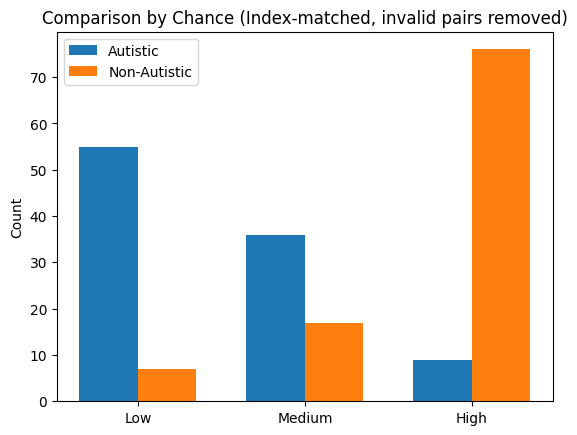

In [72]:
valid_values = {"low", "medium", "high"}

def get_chance(d):
    """Return normalized 'chance' string or None if missing/invalid."""
    v = d.get("chance", None)
    if not isinstance(v, str):
        return None
    v = v.strip().lower()
    return v if v in valid_values else None

# Index-matched filtering: keep only pairs where BOTH sides are valid
paired_valid = []
n_pairs = min(len(autistic_results_loaded), len(non_autistic_results_loaded))
for a_dict, b_dict in zip(autistic_results_loaded[:n_pairs], non_autistic_results_loaded[:n_pairs]):
    a = get_chance(a_dict)
    b = get_chance(b_dict)
    if a is not None and b is not None:
        paired_valid.append((a, b))

# Split back into two aligned lists
autistic_clean = [a for a, _ in paired_valid]
non_autistic_clean = [b for _, b in paired_valid]

print("Total pairs considered:", n_pairs)
print("Valid, aligned pairs kept:", len(paired_valid))
print("Dropped pairs:", n_pairs - len(paired_valid))

# Counts
categories = ["low", "medium", "high"]
autistic_counts = Counter(autistic_clean)
non_autistic_counts = Counter(non_autistic_clean)

autistic_values = [autistic_counts.get(cat, 0) for cat in categories]
non_autistic_values = [non_autistic_counts.get(cat, 0) for cat in categories]

# Plot (grouped bars)
x = range(len(categories))
bar_width = 0.35

plt.bar([i - bar_width/2 for i in x], autistic_values, width=bar_width, label="Autistic")
plt.bar([i + bar_width/2 for i in x], non_autistic_values, width=bar_width, label="Non-Autistic")

plt.xticks(x, [c.capitalize() for c in categories])
plt.ylabel("Count")
plt.title("Comparison by Chance (Index-matched, invalid pairs removed)")
plt.legend()
plt.show()